In [60]:
from pyhive import hive
import pandas as pd
pd.core.common.is_list_like = pd.api.types.is_list_like
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import pandasql as ps
from pandasql import sqldf
import os
import re
import seaborn as sns
import matplotlib.pyplot as plt
import math

sns.set(font_scale=3)
sns.set(color_codes=True)
%matplotlib inline

from sklearn.manifold import TSNE
from sklearn import preprocessing
from sklearn import model_selection
import shap

In [12]:
def replace_space_in_col_names(df):
    new_cols = [x.replace(" ","_") for x in df.columns]
    df.columns = new_cols

In [51]:
ahd_definitive_cols_mapping = {'beds':'NoofStaffedBeds',
                               'Total_Discharges':'NoofDischarges',
                               'Net_Patient_Rev_2016':'Net_Patient_Revenue',
                               'Net_Patient_Rev_2017':'Net_Patient_Revenue17',
                              'Pharmacy_Total_Cost':'Pharmacy_Costs',
                              'cmi_recent_value':'Case_Mix_Index',
                              'Provider_ID':'Provider_Number'}

third_party_lead_scoring_df_unscaled_joined = pd.read_csv("../QuVa_Featurizer/new_accounts_rollup/new_accounts_rollup_QuVa_Third_Party_Lead_scores.csv")
third_party_lead_scoring_df_unscaled_joined = third_party_lead_scoring_df_unscaled_joined[list(ahd_definitive_cols_mapping.keys())]
third_party_lead_scoring_df_unscaled_joined["Provider_ID"] = third_party_lead_scoring_df_unscaled_joined["Provider_ID"].astype(str)
third_party_lead_scoring_df_unscaled_joined["Provider_ID"] = third_party_lead_scoring_df_unscaled_joined["Provider_ID"].apply(lambda x : x.zfill(6))

definitive_df = pd.read_excel("../../data/DefinitiveHealthData.xlsx",0)
replace_space_in_col_names(definitive_df)

definitive_df["Provider_Number"] = definitive_df["Provider_Number"].astype(str)
definitive_df["Provider_Number"]= definitive_df["Provider_Number"].apply(lambda x : x.zfill(6))
definitive_df["Net_Patient_Revenue17"] = definitive_df["Net_Patient_Revenue"]

definitive_df = definitive_df[list(ahd_definitive_cols_mapping.values())]







In [58]:
ahd_definitive_joined_df = pd.merge(third_party_lead_scoring_df_unscaled_joined,definitive_df,left_on="Provider_ID" , right_on="Provider_Number")
for c in ahd_definitive_joined_df.columns:
    ahd_definitive_joined_df[c] = ahd_definitive_joined_df[c].astype(str)
    ahd_definitive_joined_df[c] = ahd_definitive_joined_df[c].apply(lambda x : x.replace(',',''))
    ahd_definitive_joined_df[c] = ahd_definitive_joined_df[c].astype(float)
    
for k,v in ahd_definitive_cols_mapping.items():
    ahd_definitive_joined_df[k] = ahd_definitive_joined_df[k].astype(float)
    ahd_definitive_joined_df[v] = ahd_definitive_joined_df[v].astype(float)
    ahd_definitive_joined_df[k+"_diff"] = np.abs(ahd_definitive_joined_df[k] - ahd_definitive_joined_df[v])
    
#ahd_definitive_joined_df["Provider_ID"] = ahd_definitive_joined_df["Provider_ID"].astype(int)

In [62]:
ahd_definitive_joined_df["is_2016_data"] = ahd_definitive_joined_df.apply(lambda x : True if x["Net_Patient_Rev_2016"] - x["Net_Patient_Revenue"] == 0 else False ,axis=1)
ahd_definitive_joined_df["is_2017_data"] = ahd_definitive_joined_df.apply(lambda x : True if x["Net_Patient_Rev_2017"] - x["Net_Patient_Revenue17"] == 0 else False ,axis=1)

In [139]:
1939/((2760 + 437))

0.6065060994682515

In [64]:
ahd_definitive_joined_df.groupby(["is_2016_data","is_2017_data"]).count()["Provider_ID"].reset_index()

,is_2016_data,is_2017_data,Provider_ID
0,False,False,437
1,False,True,2760
2,True,False,1939
3,True,True,17


In [65]:
len(ahd_definitive_joined_df)

5153

In [136]:
ahd_definitive_joined_17_only_df = ahd_definitive_joined_df[ahd_definitive_joined_df.is_2017_data == True]
ahd_definitive_joined_17_only_df = ahd_definitive_joined_17_only_df[ahd_definitive_joined_17_only_df.Total_Discharges > 0]
ahd_definitive_joined_17_only_df = ahd_definitive_joined_17_only_df[ahd_definitive_joined_17_only_df.NoofStaffedBeds > 0]
ahd_definitive_joined_17_only_df.head().T

i = 0
j=0
aggergated_diff = pd.DataFrame(columns=["agg_diff","diff_percentage"])
for k,v in ahd_definitive_cols_mapping.items():
    ahd_definitive_joined_17_only_df[k] = ahd_definitive_joined_17_only_df[k].astype(float)
    ahd_definitive_joined_17_only_df[v] = ahd_definitive_joined_17_only_df[v].astype(float)
    diff = np.abs(ahd_definitive_joined_17_only_df[k].sum() - ahd_definitive_joined_17_only_df[v].sum())/ahd_definitive_joined_17_only_df[v].sum()
    aggergated_diff = aggergated_diff.append({"agg_diff":k, "diff_percentage" : diff * 100},ignore_index=True)

    

In [137]:
aggergated_diff

,agg_diff,diff_percentage
0,beds,11.772775
1,Total_Discharges,0.013425
2,Net_Patient_Rev_2016,4.819779
3,Net_Patient_Rev_2017,0.000000
4,Pharmacy_Total_Cost,0.064062
5,cmi_recent_value,0.100158
6,Provider_ID,0.000000


In [133]:
ahd_definitive_joined_17_only_df.head()

,beds,Total_Discharges,Net_Patient_Rev_2016,Net_Patient_Rev_2017,Pharmacy_Total_Cost,cmi_recent_value,Provider_ID,NoofStaffedBeds,NoofDischarges,Net_Patient_Revenue,...,Provider_Number,beds_diff,Total_Discharges_diff,Net_Patient_Rev_2016_diff,Net_Patient_Rev_2017_diff,Pharmacy_Total_Cost_diff,cmi_recent_value_diff,Provider_ID_diff,is_2016_data,is_2017_data
2,74.0,1957.0,71547155.0,71913315.0,3528174.0,1.1822,220030.0,46.0,1957.0,71913315.0,...,220030.0,28.0,0.0,366160.0,0.0,0.0,0.0522,0.0,False,True
4,343.0,13057.0,268435806.0,296444846.0,24891016.0,1.3813,220066.0,263.0,13057.0,296444846.0,...,220066.0,80.0,0.0,28009040.0,0.0,0.0,0.0187,0.0,False,True
15,272.0,17048.0,419713344.0,439914198.0,37411569.0,1.5348,220176.0,259.0,17048.0,439914198.0,...,220176.0,13.0,0.0,20200854.0,0.0,0.0,0.0148,0.0,False,True
21,352.0,11654.0,232827067.0,229637681.0,8165837.0,1.3813,220080.0,335.0,11654.0,229637681.0,...,220080.0,17.0,0.0,3189386.0,0.0,0.0,0.0113,0.0,False,True
26,215.0,8390.0,178434904.0,184242239.0,6598984.0,1.3159,220126.0,154.0,8390.0,184242239.0,...,220126.0,61.0,0.0,5807335.0,0.0,0.0,0.0241,0.0,False,True


count    1927.000000
mean       20.802283
std        50.699518
min         0.000000
25%         0.000000
50%         0.000000
75%        22.000000
max       774.000000
Name: beds_diff, dtype: float64

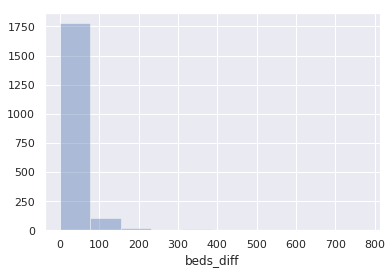

In [134]:
sns.distplot( ahd_definitive_joined_17_only_df["beds_diff"].fillna(0),kde=False,bins=10)
ahd_definitive_joined_17_only_df["beds_diff"].describe()

In [135]:
ahd_definitive_joined_17_only_df[["Provider_ID","Total_Discharges_diff"]].sort_values(by="Total_Discharges_diff",ascending=False)
d = ahd_definitive_joined_17_only_df[ahd_definitive_joined_17_only_df.Provider_ID == 450388]
len(ahd_definitive_joined_df[ahd_definitive_joined_df.Total_Discharges == 0])
ahd_definitive_joined_17_only_df[["Provider_ID","beds","NoofStaffedBeds","beds_diff"]].sort_values(by="beds_diff",ascending=False)
#len(ahd_definitive_joined_17_only_df[ahd_definitive_joined_17_only_df.beds_diff != 0])

,Provider_ID,beds,NoofStaffedBeds,beds_diff
3435,50668.0,780.0,6.0,774.0
4071,174006.0,99.0,613.0,514.0
208,330233.0,797.0,288.0,509.0
3284,50135.0,579.0,100.0,479.0
904,100029.0,760.0,305.0,455.0
899,100277.0,454.0,32.0,422.0
173,330204.0,912.0,527.0,385.0
203,330195.0,1493.0,1116.0,377.0
195,330006.0,473.0,124.0,349.0
1215,180040.0,788.0,442.0,346.0


In [129]:
pd.qcut(ahd_definitive_joined_17_only_df["beds_diff"],3,labels=False)

ValueError: Bin edges must be unique: array([   0.        ,    0.        ,   10.33333333, 1004.        ]).
You can drop duplicate edges by setting the 'duplicates' kwarg